In [1]:
import pandas as pd
import numpy as np
import pickle
import datetime
import pytz
from tqdm.notebook import tqdm, trange

# Model dev
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

/Users/adityanaik/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/adityanaik/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/adityanaik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


**Section 1: Data Cleaning**

Like with any model development process, we will begin by sifting through our dataset and extracting only the required features.

In [ ]:
elo_df = pd.read_csv("./mlb_elo.csv")

In [ ]:
elo_df = elo_df.loc[elo_df['season'] >= 2000]
elo_df = elo_df.loc[elo_df['season'] <= 2020]
# elo_df = elo_df[~elo_df['pitcher1'].str.contains(r'[0-9]')]
# elo_df = elo_df[~elo_df['pitcher2'].str.contains(r'[0-9]')]

elo_df['date']= pd.to_datetime(elo_df['date'])

elo_df.head()

In [ ]:
elo_df.to_csv( "elo_cleaned.csv")

In [ ]:
elo1_pre = 1531.8233671069
elo2_pre = 1456.6148797361
elo1_post = 1529.9288796768
elo2_post = 1458.5093671663

trans_rating1 = 10**(elo1_pre / 400.0)
trans_rating2 = 10**(elo2_pre / 400.0)

exp_score1 = elo1_pre / (elo1_pre + elo2_pre)
exp_score2 = elo2_pre / (elo1_pre + elo2_pre)

win_loss1 = 0
win_loss2 = 1

# calculate k
k1 = (elo1_post - elo1_pre) / (win_loss1 - exp_score1)
k2 = (elo2_post - elo2_pre) / (win_loss2 - exp_score2)

print("K1: " + str(k1))
print("K2: " + str(k2))

# 4.64
# 4.60
# 5.10



In [ ]:
def elo_k(point_diff, elo_diff):
    k = 32

    if point_diff>0:
        multiplier=(point_diff)**(0.5)/(10+0.01*(elo_diff))
    else:
        multiplier=(-point_diff)**(0.5)/(10+0.01*(-elo_diff))
    return k*multiplier

print(elo_k(-1, elo1_pre - elo2_pre))

In [ ]:
loaded_something = pickle.load(open('2019_data_june23.pickle', 'rb'))
loaded_something.head()

In [ ]:
game_log_df = pd.read_csv("./game_logs_00_20.csv")
game_log_df['date']= pd.to_datetime(game_log_df['date'])
game_log_df['h_team'] = game_log_df['h_team'].astype(str)
game_log_df['a_team'] = game_log_df['a_team'].astype(str)

# Handle alternate team abbreviation
game_log_df["h_team"].replace({"NYN": "NYM", "CHN": "CHC", "FLO": "FLA", "MON": "WSN", "SLN": "STL", "KCA": "KCR", "TBA": "TBD", "SDN": "SDP", "NYA": "NYY", "LAN": "LAD", "WAS": "WSN", "MIA": "FLA", "CHA": "CHW", "SFN": "SFG", "nan": float("NaN")}, inplace=True)

game_log_df.dropna(subset=["a_team", "h_team"], inplace=True)

game_log_df.head()

In [ ]:
new_df = pd.merge(game_log_df, elo_df,  how='left', left_on=['date','a_team', 'h_team'], right_on = ['date','team2', 'team1'])
new_df.dropna(subset=["a_team", "h_team", "team1", "team2"], inplace=True)
new_df.head()

In [ ]:
new_df.drop(new_df.iloc[:, 77:161], inplace=True, axis=1)
new_df = new_df.drop(['game_num', 'day_of_week', 'a_league', 'h_league', 'a_game_num', 'h_game_num', 'tot_oits', 'day_night', 'completion', 'forfeit', 'protest', 'park_id', 'attendance', 'tot_min', 'a_line_score', 'h_line_score', 'a_first_interference', 'h_first_interference', 'a_sac_hits', 'h_sac_hits', 'a_pitchers_used', 'h_pitchers_used', 'a_team_earned_runs', 'h_team_earned_runs', 'a_passed_balls', 'h_passed_balls', 'neutral', 'playoff'], axis=1)
# 1 is home, 2 is away
new_df = new_df.drop(['pitcher1', 'pitcher2', 'rating1_pre', 'rating2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post', 'rating_prob1', 'rating_prob2', 'rating1_post', 'rating2_post', 'team1', 'team2', 'season', 'score1', 'score2'], axis=1)
new_df.head()

In [ ]:
final_df = pd.DataFrame()
elo_df2_builder = {
    'h_elo': [],
    'a_elo': [],
    'h_pitch_rgs': [],
    'a_pitch_rgs': [],
    'home_win': []
}

p_bar = tqdm(total=len(new_df))
for index, row in new_df.iterrows(): 
    h_team = row['h_team']
    a_team = row['a_team']
    curr_date = row['date']
    ten_before = curr_date - datetime.timedelta(days=10)

    # Home team stats
    temp_df = new_df[new_df['date'] < curr_date]
    temp_df = temp_df[temp_df['date'] >= ten_before]
    temp_df.loc[(temp_df['a_team'] == h_team) | (temp_df['h_team'] == h_team) | (temp_df['a_team'] == a_team) | (temp_df['h_team'] == a_team)]
    
    avg_builder = {}
    for col in new_df.columns:
        if col.startswith('h_') or col.startswith('a_'):
            avg_builder[col] = []
    
    for index2, row2 in temp_df.iterrows():
        if row2['h_team'] == h_team:
            for col in temp_df:
                if col.startswith('h_'):
                    avg_builder['h_' + col[2:]].append(row2[col])
        elif row2['a_team'] == h_team:
            for col in temp_df:
                if col.startswith('a_'):
                    avg_builder['h_' + col[2:]].append(row2[col])

        if row2['h_team'] == h_team:
            for col in temp_df:
                if col.startswith('h_'):
                    avg_builder['a_' + col[2:]].append(row2[col])
        elif row2['a_team'] == h_team:
            for col in temp_df:
                if col.startswith('a_'):
                    avg_builder['a_' + col[2:]].append(row2[col])

    avg_df = pd.DataFrame(avg_builder)
    avg_series = avg_df.mean()
    
    final_df = final_df.append(avg_series, ignore_index=True)
    elo_df2_builder['h_elo'].append(row['elo1_pre'])
    elo_df2_builder['a_elo'].append(row['elo2_pre'])
    elo_df2_builder['h_pitch_rgs'].append(row['pitcher1_rgs'])
    elo_df2_builder['a_pitch_rgs'].append(row['pitcher2_rgs'])
    if row['h_runs'] > row['a_runs']:
        elo_df2_builder['home_win'].append(1)
    else:
        elo_df2_builder['home_win'].append(0)


    p_bar.update(1)

elo_df2 = pd.DataFrame(elo_df2_builder)
final_df = pd.concat([final_df, elo_df2], axis=1)
final_df = final_df.drop(['h_team', 'a_team'], axis=1)
final_df.dropna(inplace=True)

final_df.head()

In [ ]:
final_df.to_csv( "training_data.csv")

**Section 2: The Model**

Note that we will develop 2 models, one including a projected pitcher and the other without

The following model is developed for data *with* a pitcher rating included

In [2]:
df_with_pitcher = pd.read_csv("./training_data.csv")
df_with_pitcher = df_with_pitcher.loc[:, ~df_with_pitcher.columns.str.contains('^Unnamed')]

In [3]:
y = df_with_pitcher['home_win']
df_with_pitcher.drop(columns=['home_win'], inplace=True)
X = df_with_pitcher
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X.head()

,a_2_plays,a_3_plays,a_assists,a_at_bats,a_balks,a_bases_stolen,a_caught_stealing,a_doubles,a_errors,a_grounded_to_double,...,h_runs,h_sac_flies,h_strikeouts,h_triples,h_walks,h_wild_pitches,h_elo,a_elo,h_pitch_rgs,a_pitch_rgs
0,1.0,0.0,12.0,30.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2.0,0.0,6.0,0.0,1.0,0.0,1553.796,1481.365,54.127,50.678
1,0.0,0.0,8.0,19.0,0.0,0.0,0.0,1.0,2.0,0.0,...,3.0,0.0,4.0,0.0,1.0,0.0,1535.065,1483.306,54.683,47.400
2,0.0,0.0,8.0,31.0,0.0,0.0,0.0,0.0,2.0,0.0,...,4.0,0.0,9.0,0.0,3.0,0.0,1507.673,1477.837,53.279,46.325
3,0.0,0.0,7.0,32.0,0.0,0.0,0.0,1.0,1.0,1.0,...,6.0,0.0,3.0,0.0,0.0,0.0,1543.445,1485.881,52.733,45.771
4,0.5,0.0,11.0,31.5,0.0,1.0,0.5,1.0,0.0,0.5,...,2.5,0.0,5.0,0.0,2.5,0.0,1551.499,1483.662,61.106,48.920


XGBoost

In [4]:
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

# data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_clf = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xgb_rscv = RandomizedSearchCV(xg_clf, param_distributions = parameters, scoring = "f1_micro",
                             cv = 10, verbose = 3, random_state = 40 )
model_xgboost = xgb_rscv.fit(X_train, y_train)

5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0, score=0.565, total=  18.3s
[CV] subsample=0.5, reg_lambda=4.5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0 
[CV]  subsample=0.5, reg_lambda=4.5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0, score=0.573, total=  18.3s
[CV] subsample=0.5, reg_lambda=4.5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0 
[CV]  subsample=0.5, reg_lambda=4.5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0, score=0.571, total=  18.4s
[CV] subsample=0.5, reg_lambda=4.5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0 
[CV]  subsampl

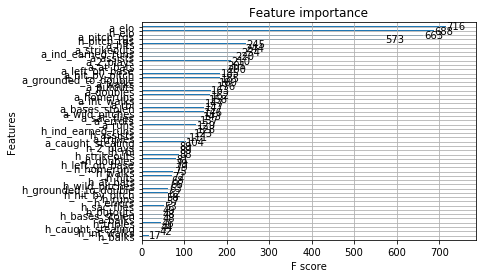

<Figure size 1152x864 with 0 Axes>

In [5]:
xgb.plot_importance(model_xgboost.best_estimator_._Booster)
plt.figure(figsize = (16, 12))
plt.show()

In [6]:
xg_probs = model_xgboost.predict_proba(X_test)

In [7]:
y_test_pred = model_xgboost.predict(X_test)
mse = mean_squared_error(y_test_pred, y_test)
mse

0.43346276032474407

In [8]:
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 56.65%


In [9]:
pickle.dump(model_xgboost, open('../../hoth/mlb_pregame_prediction_with_pitcher.pkl', 'wb'))

Now we use the same model without the pitcher game score

In [14]:
df_without_pitcher = pd.read_csv("./training_data.csv")
df_without_pitcher = df_without_pitcher.loc[:, ~df_without_pitcher.columns.str.contains('^Unnamed')]
df_without_pitcher.drop(columns=['h_pitch_rgs', 'a_pitch_rgs'], inplace=True)

In [15]:
y = df_without_pitcher['home_win']
df_without_pitcher.drop(columns=['home_win'], inplace=True)
X = df_without_pitcher
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X.head()

,a_2_plays,a_3_plays,a_assists,a_at_bats,a_balks,a_bases_stolen,a_caught_stealing,a_doubles,a_errors,a_grounded_to_double,...,h_putouts,h_rbi,h_runs,h_sac_flies,h_strikeouts,h_triples,h_walks,h_wild_pitches,h_elo,a_elo
0,1.0,0.0,12.0,30.0,0.0,1.0,0.0,0.0,0.0,1.0,...,27.0,2.0,2.0,0.0,6.0,0.0,1.0,0.0,1553.796,1481.365
1,0.0,0.0,8.0,19.0,0.0,0.0,0.0,1.0,2.0,0.0,...,16.0,3.0,3.0,0.0,4.0,0.0,1.0,0.0,1535.065,1483.306
2,0.0,0.0,8.0,31.0,0.0,0.0,0.0,0.0,2.0,0.0,...,27.0,4.0,4.0,0.0,9.0,0.0,3.0,0.0,1507.673,1477.837
3,0.0,0.0,7.0,32.0,0.0,0.0,0.0,1.0,1.0,1.0,...,27.0,6.0,6.0,0.0,3.0,0.0,0.0,0.0,1543.445,1485.881
4,0.5,0.0,11.0,31.5,0.0,1.0,0.5,1.0,0.0,0.5,...,27.0,2.5,2.5,0.0,5.0,0.0,2.5,0.0,1551.499,1483.662


In [16]:
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

# data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_clf = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xgb_rscv = RandomizedSearchCV(xg_clf, param_distributions = parameters, scoring = "f1_micro",
                             cv = 10, verbose = 3, random_state = 40 )
model_xgboost = xgb_rscv.fit(X_train, y_train)

5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0, score=0.565, total=  16.9s
[CV] subsample=0.5, reg_lambda=4.5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0 
[CV]  subsample=0.5, reg_lambda=4.5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0, score=0.569, total=  17.2s
[CV] subsample=0.5, reg_lambda=4.5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0 
[CV]  subsample=0.5, reg_lambda=4.5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0, score=0.562, total=  17.2s
[CV] subsample=0.5, reg_lambda=4.5, reg_alpha=1, n_estimators=500, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=1.0 
[CV]  subsampl

In [17]:
y_test_pred = model_xgboost.predict(X_test)
mse = mean_squared_error(y_test_pred, y_test)
mse

0.4309918813978115

In [18]:
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 56.90%


In [19]:
pickle.dump(model_xgboost, open('../../hoth/mlb_pregame_prediction_without_pitcher.pkl', 'wb'))